# UCM Applied Mathematics Department's Problem of the Month

February 2022

Andrew Lin

## Summary
###### (Skip to the end to see why I failed to do this analytically)
**I highly recommend viewing the [HTML version](https://classAndrew.github.io/posts/ampom_feb_2022) or the [Jupyter Notebook](https://github.com/classAndrew/ampom_feb_2022/blob/main/ampom_feb_2022.ipynb) itself instead**
 
All code and data is found [here](https://github.com/classAndrew/ampom_feb_2022/blob/main/data.txt).

> The average distance between two points chosen within a unit circle is approximately `0.9054` and

> The probability that the distance between two points chosen within a unit circle is less than 1 is `0.5865`.


# Approaching the Problem Numerically
###### (Skip to the end to see why I failed to do this analytically)

## The Monte Carlo Approximation
### What is a random point inside the circle?
Without carefully considering the question, I jumped straight to that a random point within the circle, given a random $0 \leq \theta \leq 2\pi$, and $0 \leq r \leq 1$ is simply

$x = r\cos(\theta) \\ y = r\sin(\theta)$

But before I move on, I'd like to show you why this is not correct and leads to a bias of density near the center.

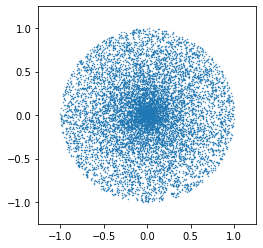

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math 

thetas = np.random.uniform(low=0, high=2*math.pi, size=10000)
radius = np.random.uniform(low=0, high=1, size=10000)
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.scatter(np.cos(thetas)*radius, np.sin(thetas)*radius, s=0.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Note how the dots seem to **cluster near the center**? This is a problem as it is not a truly random (that is each point has an equal probability of being chosen) method of generating random points.

The next best method is the `choose and reject` algorithm:
1. Pick 2 independently random values $(x, y)$ within the range [-1, 1]
2. If $x^2 + y^2 \leq 1$, then hooray! Random point located.
3. Repeat the process if it's outside the circle

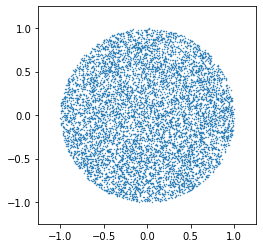

In [8]:
x = np.random.uniform(low=-1, high=1, size=10000)
y = np.random.uniform(low=-1, high=1, size=10000)

dist = x**2+y**2
x = x[dist <= 1]
y = y[dist <= 1]
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x, y, s=0.2)
plt.show()

The `choose and reject` method seems to work since the clustering issue is now gone. I will continue using this method throughout the Monte Carlo approach though. I'm sure there are other ways for choosing random points inside a circle.

## The Approximation Algorithm

Let's revisit the problem statement:

> What is the average distance between the two[random] points?

> What is the probability that the distance between the two[random] points is < 1?

First, I pick any two points in the circle. We generated a collection of random points earlier using the `choose and reject` method. 

Next, I find the euclidean distance between those two points. An optimization that I can apply is to multiply this value by two and ignore the order of the pair of points.

I do the above pairwise for the entire collection of points.

After accumulating the pairwise distances of the collection of points, sum the values and divide by the number of pairs ($n^2$ pairs).

Part 2 can be approximated by adding to a counter if the distance is less than 1 (adding 2 since I ignore the order)

#### Algorithm Analysis

The algorithm described will run in $O(n^2)$ time, given $n$ points.

This is because the number of pairs considered is $\frac{n(n+1)}{2}$, or roughly that number of operations required.

In [27]:
import time
max_size = [50, 100, 200, 500, 1000, 2000, 3000, 5000, 10000, 15000, 20000, 25000]

for s in max_size:
    now = time.time()

    x = np.random.uniform(low=-1, high=1, size=s)
    y = np.random.uniform(low=-1, high=1, size=s)

    dist = x**2+y**2
    x = x[dist <= 1]
    y = y[dist <= 1]

    dist_sum = 0
    neighbor_count = 0
    for i in range(x.size):
        x_i, y_i = x[i], y[i]
        for j in range(i+1, x.size):
            x_j, y_j = x[j], y[j]
            dist = ((x_j-x_i)**2+(y_j-y_i)**2)**.5

            # these values are multiplied by 2 because there are two ways to make the pairings (p1, p2) and (p2, p1)
            dist_sum += dist*2
            neighbor_count += (dist < 1)*2

    print("%7d points - Average dist: %7.5f  |  Less than 1: %7.5f  |  %9.5fs" % (x.size, dist_sum/x.size**2, neighbor_count/x.size**2, time.time()-now))
        

     42 points - Average dist: 0.82242  |  Less than 1: 0.63832  |    0.00750s
     78 points - Average dist: 0.90010  |  Less than 1: 0.56575  |    0.01971s
    156 points - Average dist: 0.90092  |  Less than 1: 0.58752  |    0.06242s
    400 points - Average dist: 0.89858  |  Less than 1: 0.58555  |    0.37264s
    816 points - Average dist: 0.88385  |  Less than 1: 0.60397  |    1.72450s
   1573 points - Average dist: 0.90548  |  Less than 1: 0.58570  |    5.85811s
   2373 points - Average dist: 0.89932  |  Less than 1: 0.59255  |   13.63285s
   3915 points - Average dist: 0.90752  |  Less than 1: 0.58398  |   40.81342s
   7893 points - Average dist: 0.91044  |  Less than 1: 0.58180  |  150.64175s
  11753 points - Average dist: 0.90875  |  Less than 1: 0.58339  |  321.76805s
  15736 points - Average dist: 0.90582  |  Less than 1: 0.58594  |  652.27925s
  19724 points - Average dist: 0.90294  |  Less than 1: 0.58862  |  914.47200s


So according to the numerical approach, the average distance between two random points within a circle is somewhere around `0.90637` and the probability of those two points being less than 1 away is `0.58602`

## Slight Issues

Although the algorithm works in theory, it is impractical to stick to this code due to a long running time so I need to optimize it, especially because I need to take more samples.

Therefore, I chose to use the [numba](https://numba.pydata.org/numba-doc/latest/) library which JIT compiles the Python code to machine instructions along with applying autovectorization, fast math, and other optimizations.

```
=====Intel i7 8550U Numba (Monte Carlo)=====
...
21   392670.0           0.90545      0.58650   95.89512
22   471586.0           0.90565      0.58624  124.46372
23   550142.0           0.90550      0.58652  170.12948
```
Roughly a 6000x speedup


In [ ]:
import time, typing, sys
import multiprocessing as mp
import numpy as np
from numba import njit, prange

RNG = np.random # np.random.Generator(np.random.PCG64(np.random.SeedSequence().spawn(1)[0]))
CORES = 4

@njit(parallel=True, boundscheck=False)
def approx(xy) -> typing.Tuple[int, float, float]: 
    x, y = xy
    
    dist = x**2+y**2
    x = x[dist <= 1]
    y = y[dist <= 1]

    dist_sum = 0
    neighbor_count = 0

    for i in prange(x.size):
        x_i, y_i = x[i], y[i]
        for j in prange(i+1, x.size):
            x_j, y_j = x[j], y[j]
            dist = ((x_j-x_i)**2+(y_j-y_i)**2)**.5

            # these values are multiplied by 2 because there are two ways to make the pairings (p1, p2) and (p2, p1)
            dist_sum += dist*2
            neighbor_count += (dist < 1)*2

    return x.size, dist_sum/x.size**2, neighbor_count/x.size**2

if __name__ == "__main__":
    max_pts = int(sys.argv[1])

    if len(sys.argv) >= 3 and sys.argv[2] == "multisample":
        sys.stderr.write(f"[!] Multisampling enabled over {CORES} processes. Expect computation to take longer\n")
        now = time.time()
        # np.random isn't thread safe :(
        data = [(RNG.uniform(low=-1, high=1, size=max_pts), RNG.uniform(low=-1, high=1, size=max_pts)) for _ in range(CORES)]
        pool = mp.Pool(processes=4)
        result = np.array(pool.map(approx, data)).T
        print("%7d points - Average dist: %7.7f  |  Less than 1: %7.7f  |  %9.5fs" % 
            (np.mean(result[0]), np.mean(result[1]), np.mean(result[2]), time.time()-now))
        pool.close()
    
    else:
        sys.stderr.write(f"[!] Multisampling is disabled, add 'multisample' as an argument to enable\n")
        now = time.time()
        result = approx((RNG.uniform(low=-1, high=1, size=max_pts), RNG.uniform(low=-1, high=1, size=max_pts)))
        print("%7d points - Average dist: %7.7f  |  Less than 1: %7.7f  |  %9.5fs" % 
            (result[0], result[1], result[2], time.time()-now))

The next problem is that the pseudorandom number generator or the seed could just be really bad and give numbers that throw off the approximation, so it's time to switch approaches.

## The Grid Sampling Approach

[Grid sampling](https://www.midwesternbioag.com/fall-soil-sampling-grid-not-grid) is a method used in studying soil composition. You divide the land into an array of cells, pick a point, and make that point represent the cell.

If you do this over a sufficiently large number of cells, then you can get a good idea of what the entire area's soil is like.


I'm going to apply this concept to the numerical approach: instead of generating the random numbers and being subject to the possibility of 'being unlucky', I'm going to split a unit square into an equally sliced array and see which points lie within a unit circle!

Grid sampling will guarantee the convergence of the digits after `0.90` and `0.586`.

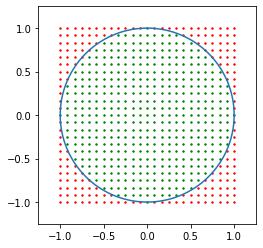

In [16]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 25), np.linspace(-1, 1, 25))
x, y = xx.ravel(), yy.ravel()
dist = x**2+y**2
plt.scatter(x[dist>1], y[dist>1], s=2, c='red')
plt.scatter(x[dist <= 1], y[dist <= 1], s=2, c='green')
plt.plot(np.cos(np.linspace(0, 2*3.141592, 400)), np.sin(np.linspace(0, 2*3.141592, 400)))
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Although grid sampling will ensure that the matching digits of each succesive run are a good approximation of the correct answer, it is extremely computationally expensive to sample across a sufficient number of points.

Thankfully, the Apple M1 8-Core GPU is able to handle this within a reasonable number of time.
I switched to [Taichi](https://github.com/taichi-dev/taichi) which compiles Python through a GPU backend (Apple Metal) to achieve extreme performance.

```
=====Apple M1 8-Core GPU (Taichi + Apple Metal Backend) (Grid Sampling)=====
    In Circle  Average Distance  Less Than 1       Time
20  3460296.0          0.905301     0.586506  110.97844
21  3797716.0          0.905390     0.586521  133.24946
22  4150980.0          0.905866     0.586524  161.65900
```
Note that the GPU is doing roughly 8 trillion operations over 161 seconds. (53 GFLOPS)

I can comfortably say that the first few digits of the average distance is `0.905` and that the probability that the distance between two points is less than 1 is `0.5865`.

### Hunting for the Fourth Digit
Even though 3 digits are enough for submission, I wanted to find the fourth digit of the average distance just to be sure.

I can't rely on the Taichi + Apple Metal backend anymore because it only allows for 32-bit floats, which isn't enough precision. (The average distance starts to diverge from the previous runs at around 460k points because of the lack of precision)

### 64-Bit doubles in CUDA
Using the [CUDA](https://en.wikipedia.org/wiki/CUDA) programming language, I can write code on heavy lifting GPUs that Google Colab has available.

I ported the algorithm to CUDA and ran it over *many* points.

```
=====Google Colab NVIDIA Tesla K80 (Grid Sampling)=====
     In Circle  Average Distance  Total Points  Side Interval   Blocks  Threads
...
33   9079144.0          0.905412    11560000.0        34000.0  45157.0    256.0
34   9620991.0          0.905408    12250000.0        35000.0  47852.0    256.0
35  10178539.0          0.905405    12960000.0        36000.0  50625.0    256.0
```
The fourth digit seems to be a `4`! I omitted the CUDA code for probability of the distance being less than 1 because the four digits from the previous approaches already agree with each other.

```cpp
__global__
void approx(uint64_t N, double *xv, double *yv, double *avg_dist) {
  uint64_t idx = blockDim.x*blockIdx.x + threadIdx.x;
  if (idx < N) {
    double x = xv[idx], y = yv[idx]; 
    double dist = 0;
  
    for (uint64_t i = 0; i < idx; i++) {
      double dx = xv[i]-x, dy = yv[i]-y;
      dist += sqrt(dx*dx + dy*dy)*2.0;
    }
  
    avg_dist[idx] = dist/N;
  } 
}

__global__
void choose_reject(uint64_t N, double *xv, double *yv, bool *in_circle) {
  uint64_t idx = blockDim.x*blockIdx.x + threadIdx.x;
  uint64_t stride = blockDim.x*gridDim.x;
  
  for (uint64_t i = idx; i < N; i += stride) {
    double x = xv[i]; double y = yv[i];
    in_circle[i] = (x*x + y*y) <= 1.0;
  }
}
```

# Failed Approach 😔

### The Analytical Approach
#### Back to the random point in the circle...

let $D$ represent the average distance between two random points inside the circle.

let list $p$ be a list of points $(x_i, y_i)$



The goal is to some how convert this sum to an integral, but I can't do that unless I have a way of generating p.

It doesn't make any sense to embed a `choose and reject` algorithm inside an integral, so I will consider **every** point instead of a list of random ones.

Let's introduce $\alpha \in [0, 2\pi]$, $\beta \in [0, 2\pi]$, $r \in [0, 1]$, and $s \in [0, 1]$

This means we can create two points from these four parameters:

$(r \cos(\alpha),\, r \sin(\alpha)) \\
(s \cos(\beta),\, s \sin(\beta))$

And borrowing from the algorithm in the numerical approach:

$$
D=\frac{1}{n^2} \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} \sqrt{(p_{jx}-p_{ix})^2 + (p_{jy}-p_{iy})^2}
$$

When taking enough points $\left(\displaystyle\lim_{n \to +\infty}\right)$, and substituting the points with the 4 parameters, the Riemann sum turns into this awful iterated integral:



$$\displaystyle\int_{0}^{2\pi} \int_{0}^{1} \int_{0}^{2\pi} \int_{0}^{1} \sqrt{(s\cos\beta - r\cos\alpha)^2 + (s\sin\beta - r\sin\alpha)^2} \, d\alpha \, dr \, d\beta \,ds$$

There's probably some symmetry I could be using to get rid of some of the integrals or somehow change the order of integration, but I pretty much got stuck after this.